# MACD

### 賴志宏 Chih-Hung Lai

Created: 2021.12.23  Last modified:2022.01.06

%%html

<!-- ****讓表格靠左對齊**** -->
<style>
table {align:left;display:block}
</style>

## Table of Contents
1. 介紹MACD指標
2. 讀入股票資料  
3. 計算MACD線
4. 繪出MACD線與股價圖  
5. 策略1：黃金死亡交叉
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 買點分析
    5. 回溯檢驗
6. 策略2：
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗

額外參考資料

# 1. 介紹MACD指標


## MACD 的計算公式：

- [MACD指標介紹](https://rich01.com/what-is-macd-indicator/)
- [MACD簡介-日盛證券](https://www.jihsun.com.tw/md/event/jsun_school/stock12.html)
- [EMA介紹](https://www.oanda.com/bvi-ft/lab-education/technical_analysis/moving_average-exponential_smoothing_moving_average/)



## 2. 讀入股票資料

In [22]:
import pandas as pd
import numpy as np

file = "0050.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(600)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2018-10-05   84.50   84.50   83.00   83.45   26744
2018-10-08   82.95   83.40   82.50   83.00   46523
2018-10-09   83.05   83.40   82.80   83.25   20530
2018-10-11   80.15   80.15   77.35   77.40   68551
2018-10-12   77.70   80.05   77.50   80.05   23183
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[600 rows x 5 columns]


## 3. 計算MACD線

In [23]:
# Define constants
MACD_N = 9
MACD_EMA_SLOW = 26
MACD_EMA_QUICK = 12
middle_line = 0

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

tmp['ema12'] = data['Close'].ewm(span=MACD_EMA_QUICK, adjust=False).mean() # exponential moving average
tmp['ema26'] = data['Close'].ewm(span=MACD_EMA_SLOW, adjust=False).mean() # exponential moving average
print(tmp.head(10))

data['macd_DIF']  = tmp['ema12'] - tmp['ema26']                             # qucik MACD
data['macd_DEM'] = data['macd_DIF'].ewm(span = MACD_N, adjust=False).mean()# slow MACD
data['macd_BAR'] = data['macd_DIF'] - data['macd_DEM']                     # MACD bar
print(data.head(10))


                ema12      ema26
Date                            
2018-10-05  83.450000  83.450000
2018-10-08  83.380769  83.416667
2018-10-09  83.360651  83.404321
2018-10-11  82.443628  82.959556
2018-10-12  82.075377  82.744034
2018-10-15  81.633012  82.481513
2018-10-16  81.274087  82.245845
2018-10-17  80.985766  82.035042
2018-10-18  80.703340  81.821335
2018-10-19  80.487442  81.634569
             Open   High    Low  Close  Volume  macd_DIF  macd_DEM  macd_BAR
Date                                                                        
2018-10-05  84.50  84.50  83.00  83.45   26744  0.000000  0.000000  0.000000
2018-10-08  82.95  83.40  82.50  83.00   46523 -0.035897 -0.007179 -0.028718
2018-10-09  83.05  83.40  82.80  83.25   20530 -0.043670 -0.014478 -0.029192
2018-10-11  80.15  80.15  77.35  77.40   68551 -0.515929 -0.114768 -0.401161
2018-10-12  77.70  80.05  77.50  80.05   23183 -0.668657 -0.225546 -0.443111
2018-10-15  79.50  79.50  78.65  79.20   49299 -0.848501 -0.35013

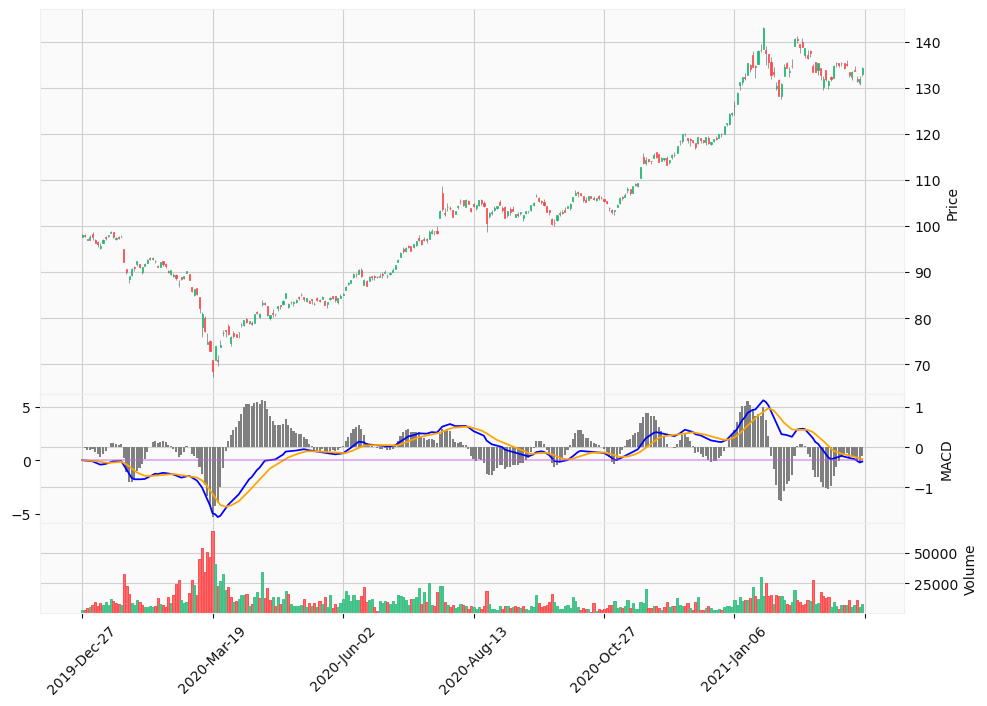

In [7]:
import mplfinance as mpf

plots = [
          mpf.make_addplot(data['macd_BAR'], type = 'bar', panel = 1, color = 'grey', ylabel = 'MACD'),
          mpf.make_addplot(data['macd_DIF'], panel = 1, color = 'blue'),
          mpf.make_addplot(data['macd_DEM'], panel = 1, color = 'orange'),
    
          # Add zero line
          mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#bf5ce0', alpha=0.5),
       ]

# # make the graph(plot)
mpf.plot(data,
         type='candle',   # candlestick chart of stock price
         volume=True,     # plots trading volume as well
         volume_panel=2,
         figscale=1.5,
         addplot = plots,
         style='yahoo', 
         panel_ratios = (3, 1, 0.7)
)

## 4. 策略1：黃金死亡交叉

### 4.1 黃金死亡交叉：策略介紹
快線(DIF)在0軸之上突破慢線(DEM)，代表行情轉強，可以買進 （次日）

買入：快線(DIF)向上突破慢線(DEM)，且兩者皆>0  
賣出：快線(DIF)向下突破慢線(DEM)，且兩者皆<0  

---

買點範例分析：（非實際買點）


| 日期 | 線圖 | 近期K線 | 價格趨勢 | 結果 |
|---|---|---|---|---|
| 2018/10/31 | 出現黃金交叉 | 紅K | 後市漲 | 正確 |
| 2019/01/09 | 出現黃金交叉 | K線轉紅 | 後市漲 | 正確 |
| 2019/03/18 | 出現黃金交叉 | K線轉紅 | 紅綠K交叉，後市跌 | 不確定 |
| 2019/04/04 | 出現黃金交叉 | K線綠轉紅 | 連續出現死亡交叉，後市跌 | 失敗 |
| 2019/04/19 | 出現黃金交叉 | 綠K上影線拉高 | 後市漲 | 正確 |  

我們也可以從這個分析中看出MACD的盲點，  
也就是進入盤整期時，會出現誤導性的金叉，  
甚至出現連續金叉死叉的情況，影響判斷。

### 4.2 黃金死亡交叉：策略買賣信號

In [24]:
# modified
# initialize 'buy' & 'sell' column by filling with 0
strategy_1 = pd.DataFrame(index=ticker.index)
strategy_1['buy'] = np.zeros(ticker.shape[0])
strategy_1['sell'] = np.zeros(ticker.shape[0])


# skip first RSI_n days
for i in range(MACD_EMA_SLOW, data.shape[0]):

    if(data['macd_DIF'][i] > 0 and data['macd_DEM'][i] > 0):
        # fast MACD  upcross slow MACD
        if((data['macd_DIF'][i-1] < data['macd_DEM'][i-1]) and
           (data['macd_DIF'][i]   > data['macd_DEM'][i]) and
           (data['macd_DIF'][i-1] < data['macd_DIF'][i])):

            strategy_1.loc[(data.index[i+1], 'buy')] = 1
            #print(strategy_1.loc[(data.index[i+1], 'buy')])
            print('buy  |', data.index[i+1], data['Open'][i+1])   # modified, buy at the opening price the next day
            
    if(data['macd_DIF'][i] < 0 and data['macd_DEM'][i] < 0):
        # fast MACD  downcross slow MACD
        if((data['macd_DIF'][i-1] > data['macd_DEM'][i-1]) and
           (data['macd_DIF'][i]   < data['macd_DEM'][i]) and
           (data['macd_DIF'][i-1] > data['macd_DIF'][i])):
            
            strategy_1.loc[(data.index[i+1], 'sell')] = 1
            print('sell |', data.index[i+1], data['Open'][i+1])  # modified, sell at the opening price the next day

sell | 2018-11-22 00:00:00 76.1
sell | 2018-12-11 00:00:00 74.5
sell | 2018-12-24 00:00:00 74.85
sell | 2019-01-04 00:00:00 72.8
sell | 2019-01-25 00:00:00 74.6
sell | 2019-02-11 00:00:00 75.35
buy  | 2019-03-18 00:00:00 77.75
sell | 2019-08-27 00:00:00 80.15
buy  | 2019-10-09 00:00:00 86.15
buy  | 2019-12-13 00:00:00 96.75
sell | 2020-02-19 00:00:00 91.15
sell | 2020-02-25 00:00:00 89.5
buy  | 2020-06-03 00:00:00 86.15
buy  | 2020-07-03 00:00:00 92.1
buy  | 2020-09-17 00:00:00 106.05
buy  | 2020-10-08 00:00:00 105.45
buy  | 2020-11-09 00:00:00 107.75
buy  | 2020-12-07 00:00:00 118.5
buy  | 2021-01-04 00:00:00 122.2
buy  | 2021-02-19 00:00:00 139.55


### 4.3 黃金死亡交叉：繪製交易點

/Users/oscar/opt/anaconda3/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


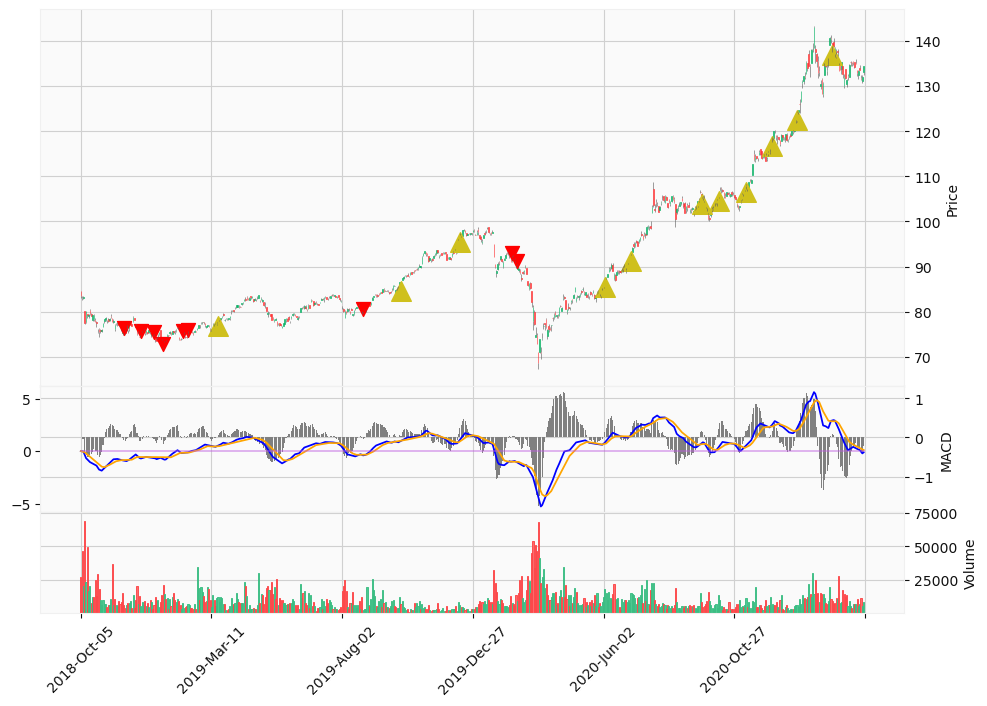

In [25]:
# modified
# Dataframes.iterrows() 會傳回索引該行以及該行的整個資料  
# 可參考 https://www.delftstack.com/zh-tw/howto/python-pandas/how-to-iterate-through-rows-of-a-dataframe-in-pandas/#pandas-dataframe-iterrows-%E9%81%8D%E6%AD%B7-pandas-%E8%A1%8C

plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():     # iterrows() 會傳回索引該行以及該行的整個資料  
    buy.append(row['Close']*0.985 if strategy_1.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_1.loc[index]['sell'] else np.nan)

plots = [
          mpf.make_addplot(data['macd_BAR'], type = 'bar', panel = 1, color = 'grey', ylabel = 'MACD'),
          mpf.make_addplot(data['macd_DIF'], panel = 1, color = 'blue'),
          mpf.make_addplot(data['macd_DEM'], panel = 1, color = 'orange'),
    
          # Add zero line
          mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#bf5ce0', alpha=0.5),
       ]
# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

# # make the graph(plot)
mpf.plot(data,
         type='candle',   # candlestick chart of stock price
         volume=True,     # plots trading volume as well
         volume_panel=2,
         figscale=1.5,
         addplot = plots,
         style='yahoo', 
         panel_ratios = (3, 1, 0.8)
)  

### 4.4 黃金死亡交叉：買點分析

買點分析表格(僅列出6個)：

| 日期 | 線圖 | 近期K線 | 價格趨勢 | 結果 |
|---|---|---|---|---|
| 2020/06/02 | 出現黃金交叉 | K線轉紅 | 後市漲 | 正確 |
| 2020/03/26 | 出現黃金交叉 | 連續紅K | 後市漲 | 正確 |
| 2020/06/02 | 出現黃金交叉 | K線轉紅 | 後市跌 | 失敗 |
| 2020/07/02 | 出現黃金交叉 | 紅K後下修 | 後市漲後接盤整 | 不確定 |
| 2020/09/16 | 出現黃金交叉 | 連續紅K | 後市漲 | 正確 |


### 4.5 黃金死亡交叉：回溯檢驗

In [26]:
# how many shares we hold, and the money balance
import time
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_1.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy ','|', index, '|', row['Close'])
    
    # sell signal or it reach ends
    elif((strategy_1.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell','|', index, '|',row['Close'], "*" , have_shares)
      
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')  # 每次買的股票，賣了都賺錢

buy  | 2019-03-18 00:00:00 | 78.1
sell | 2019-08-27 00:00:00 | 79.85 * 1
buy  | 2019-10-09 00:00:00 | 85.8
buy  | 2019-12-13 00:00:00 | 96.9
sell | 2020-02-19 00:00:00 | 92.1 * 2
buy  | 2020-06-03 00:00:00 | 86.8
buy  | 2020-07-03 00:00:00 | 92.55
buy  | 2020-09-17 00:00:00 | 105.4
buy  | 2020-10-08 00:00:00 | 106.2
buy  | 2020-11-09 00:00:00 | 108.1
buy  | 2020-12-07 00:00:00 | 118.4
buy  | 2021-01-04 00:00:00 | 124.35
buy  | 2021-02-19 00:00:00 | 138.85
sell | 2021-03-26 00:00:00 | 134.35 * 8

cumulative return rate : 25.80540014850743 %
accuracy : 100.0 %


## 5. 策略2：中線

- 買入：快線(DIF)突破0軸可以買入  (次日買進） 
- 賣出：快線(DIF)跌破0軸可以賣出  (次日賣出）


### 5.2 拉回不破：策略買賣信號

In [27]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_2 = pd.DataFrame(index=ticker.index)
strategy_2['buy'] = np.zeros(ticker.shape[0])
strategy_2['sell'] = np.zeros(ticker.shape[0])


# skip first RSI_n days
for i in range(MACD_EMA_SLOW, data.shape[0]):


    if((data['macd_DIF'][i-1] < 0) and
        (data['macd_DIF'][i]   > 0) and
        (data['macd_DIF'][i-1] < data['macd_DIF'][i])):

        strategy_2.loc[(data.index[i+1], 'buy')] = 1
        print('buy sign  |', data.index[i], '前一天DIF:', data['macd_DIF'][i-1],'當天DIF:',data['macd_DIF'][i])
        print('    次日買進日期：', data.index[i+1], '開盤價格：', data['Open'][i+1])

    if((data['macd_DIF'][i-1] > 0) and
        (data['macd_DIF'][i]   < 0) and
        (data['macd_DIF'][i-1] > data['macd_DIF'][i])):
            
        strategy_2.loc[(data.index[i+1], 'sell')] = 1
        print('sell sign |', data.index[i], '前一天DIF:', data['macd_DIF'][i-1],'當天DIF:',data['macd_DIF'][i])
        print('    次日賣出日期：', data.index[i+1], '開盤價格：', data['Open'][i+1])

buy sign  | 2019-01-21 00:00:00 前一天DIF: -0.026842408906247783 當天DIF: 0.08429731572826427
    次日買進日期： 2019-01-22 00:00:00 開盤價格： 74.4
sell sign | 2019-01-22 00:00:00 前一天DIF: 0.08429731572826427 當天DIF: -0.025029650050711894
    次日賣出日期： 2019-01-23 00:00:00 開盤價格： 74.0
buy sign  | 2019-02-14 00:00:00 前一天DIF: -0.002440499124830353 當天DIF: 0.015928448215916546
    次日買進日期： 2019-02-15 00:00:00 開盤價格： 75.3
sell sign | 2019-05-15 00:00:00 前一天DIF: 0.1474637925442579 當天DIF: -0.01630645159998778
    次日賣出日期： 2019-05-16 00:00:00 開盤價格： 79.5
buy sign  | 2019-06-20 00:00:00 前一天DIF: -0.038115356180696836 當天DIF: 0.10772856442608258
    次日買進日期： 2019-06-21 00:00:00 開盤價格： 81.1
sell sign | 2019-08-06 00:00:00 前一天DIF: 0.09748635170242892 當天DIF: -0.0829436092563327
    次日賣出日期： 2019-08-07 00:00:00 開盤價格： 80.15
buy sign  | 2019-09-04 00:00:00 前一天DIF: -0.08218551564095833 當天DIF: 0.019828668308704778
    次日買進日期： 2019-09-05 00:00:00 開盤價格： 82.55
sell sign | 2020-01-31 00:00:00 前一天DIF: 0.21476063652013977 當天DIF: -0.3286773

### 5.3 拉回不破：繪製交易點

/Users/oscar/opt/anaconda3/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


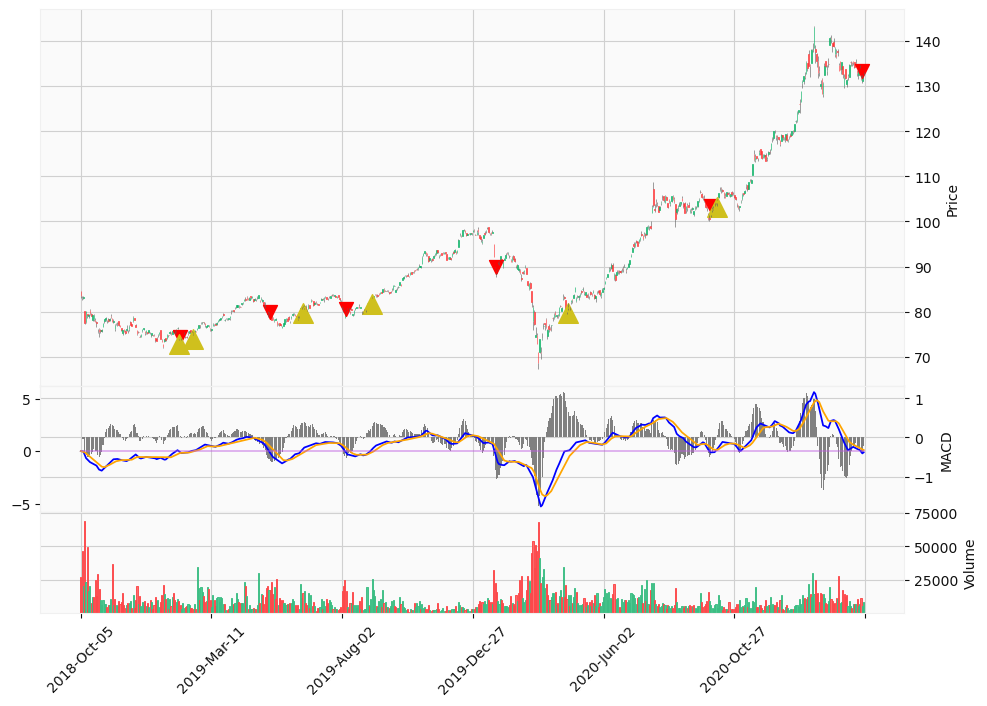

In [28]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_2.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_2.loc[index]['sell'] else np.nan)

plots = [
          mpf.make_addplot(data['macd_BAR'], type = 'bar', panel = 1, color = 'grey', ylabel = 'MACD'),
          mpf.make_addplot(data['macd_DIF'], panel = 1, color = 'blue'),
          mpf.make_addplot(data['macd_DEM'], panel = 1, color = 'orange'),
    
          # Add zero line
          mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#bf5ce0', alpha=0.5),
       ]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

# # make the graph(plot)
mpf.plot(data,
         type='candle',   # candlestick chart of stock price
         volume=True,     # plots trading volume as well
         volume_panel=2,
         figscale=1.5,
         addplot = plots,
         style='yahoo', 
         panel_ratios = (3, 1, 0.8)
)  

### 5.4 中線：回溯檢驗

In [29]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_2.loc[index]['buy'] == 1):
        balance -= row['Open']
        have_shares += 1
        print('buy ','|', index, '|', row['Open'])
    
    # sell signal or it reach ends
    elif((strategy_2.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell','|', index, '|',row['Open'], "*" , have_shares)
        
        principal = -balance
        balance += row['Open'] * have_shares
        
        # to calculate accuracy
        trade_times += 1    # 買賣次數
        if(balance > 0):
            make_money += 1  # 賣掉是賺錢的次數
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('principal:', principal)
print('賺錢次數（make_money:）', make_money)
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  | 2019-01-22 00:00:00 | 74.4
sell | 2019-01-23 00:00:00 | 74.0 * 1
buy  | 2019-02-15 00:00:00 | 75.3
sell | 2019-05-16 00:00:00 | 79.5 * 1
buy  | 2019-06-21 00:00:00 | 81.1
sell | 2019-08-07 00:00:00 | 80.15 * 1
buy  | 2019-09-05 00:00:00 | 82.55
sell | 2020-02-03 00:00:00 | 88.5 * 1
buy  | 2020-04-23 00:00:00 | 81.15
sell | 2020-09-28 00:00:00 | 101.35 * 1
buy  | 2020-10-07 00:00:00 | 104.0
sell | 2021-03-25 00:00:00 | 131.1 * 1

principal: 104.0
賺錢次數（make_money:） 4
cumulative return rate : 75.16381019569316 %
accuracy : 66.66666666666666 %


---
Other reference：

